In [3]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [4]:
output_dir = '../../split_year_models'

### Loading Data

In [5]:
filepath = '../../split_year_data'

In [6]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x90 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_90.csv')
    tdata_x90 = tdata_x90.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y90 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_90.csv')
    tdata_y90 = tdata_y90.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [7]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [18]:
test_data_x.shape

(203, 720)

In [8]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [9]:
with open('../../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

### Setting up Tables

In [10]:
# setting up the dataframe to hold test results
index_rows = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 90%', '1'), ('Threshold 90%', '2'), ('Threshold 90%', '3'), ('Threshold 90%', '4'), ('Threshold 90%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

index_cols = pd.MultiIndex.from_tuples(
    [('LightGBM', 'Relative Error'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'Relative Error'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'Relative Error'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')],
    names=['Model', 'Evaluation Metric']
)

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

Model                             LightGBM                            XGBoost  \
Evaluation Metric           Relative Error  MAE  MSE RMSE   R2 Relative Error   
Missing Data Threshold Fold                                                     
Threshold 85%          1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   
Threshold 90%          1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   
Threshold 95%          1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   
None                   1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   

Model                                            Random Forest                 \
Evaluation Metric            MAE  MSE RMSE   R2 Relative Error  MAE  MSE RMSE   
Missing Data Threshold Fold                                                     
Threshold 85%          1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
Threshold 90%          1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
Threshold 95%          1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
None                   1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   

Model                             
Evaluation Metric             R2  
Missing Data Threshold Fold       
Threshold 85%          1     NaN  
                       2     NaN  
                       3     NaN  
                       4     NaN  
                       5   

### LightGBM

#### Data Collection

In [11]:
# setting up the dataframe to hold test results

lgbm_params = pd.DataFrame(index=index_rows, columns=['number_trees', 'max_tree_depth', 'boosting_type', 
                                                     'bagging_fraction', 'bagging_freq', 'learning_rate',
                                                     'l1_norm', 'l2_norm'])

In [12]:
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        lgbm_params.loc[(thresh_name, fold_num)] = param_list

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        to_test = testing_x[train_input_data.columns].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate re
        num_predictions = len(prediction)
        re = 0
        for p in range(0, num_predictions):
            re += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        re = re/num_predictions
        #re = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'Relative Error')] = re[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/3925599995.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/3925599995.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/3925599995.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

#### Visualisations

In [29]:
lgbm_params

number_trees max_tree_depth boosting_type  \
Missing Data Threshold Fold                                             
Threshold 85%          1             240             15          dart   
                       2             271             17          dart   
                       3             172             20          dart   
                       4             118             14          dart   
                       5             274             14          dart   
Threshold 90%          1             159             19          dart   
                       2              45             25          gbdt   
                       3             146              4          gbdt   
                       4             145             20          dart   
                       5             147             23          dart   
Threshold 95%          1             203             11          dart   
                       2             294             24          dart   
                       3             235              4          dart   
                       4             280             12          dart   
                       5              82             16          dart   
None                   1             198             25          dart   
                       2              56             20          gbdt   
                       3             232             17          dart   
                       4             295             21          dart   
                       5             219             10          dart   

                            bagging_fraction bagging_freq learning_rate  \
Missing Data Threshold Fold                                               
Threshold 85%          1            0.555559            9      0.065503   
                       2            0.666009            3      0.064093   
                       3            0.806488            2      0.773626   
                       4            0.681592            7      0.456461   
                       5             0.57147            8      0.643429   
Threshold 90%          1            0.526186            4      0.116368   
                       2            0.870749            4      0.085301   
                       3            0.415389            5      0.275414   
                       4            0.534177            1       0.23742   
                       5            0.628722            2      0.548127   
Threshold 95%          1            0.647783            7      0.705388   
                       2            0.693452            8      0.089414   
                       3            0.577181           10      0.740176   
                       4            0.472856            4      0.164722   
                       5            0.778946            6      0.340605   
None                   1            0.561087            9      0.128702   
                       2            0.780787            3      0.048709   
                       3            0.636011            2      0.954213   
                       4            0.510986            9      0.111943   
                       5            0.678741            9       0.51395   

                              l1_norm   l2_norm  
Missing Data Threshold Fold                      
Threshold 85%          1     0.000432  0.000504  
                       2     0.000828  0.000927  
                       3     0.000185  0.000469  
                       4     0.000382  0.000454  
                       5     0.000796  0.000114  
Threshold 90%          1     0.000695  0.000036  
                       2     0.000719  0.000339  
                       3     0.000458  0.000013  
                       4     0.000293  0.000326  
                       5     0.000029  0.000433  
Threshold 95%          1     0.000069  0.000955  
                       2     0.000824  0.000898  
                       3     0.000259  0.000167  
                    

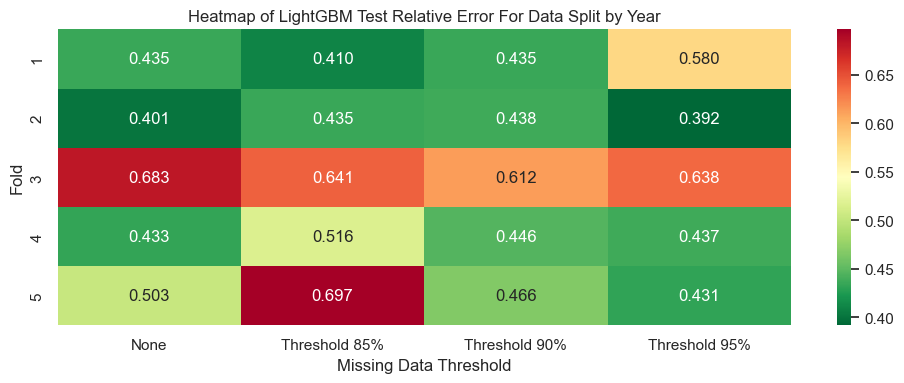

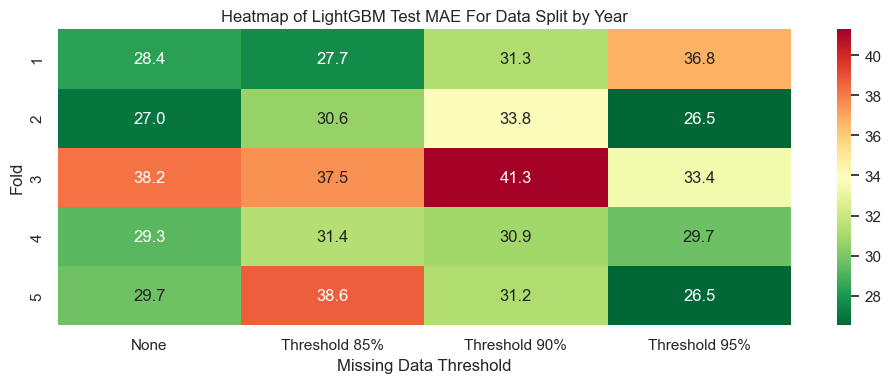

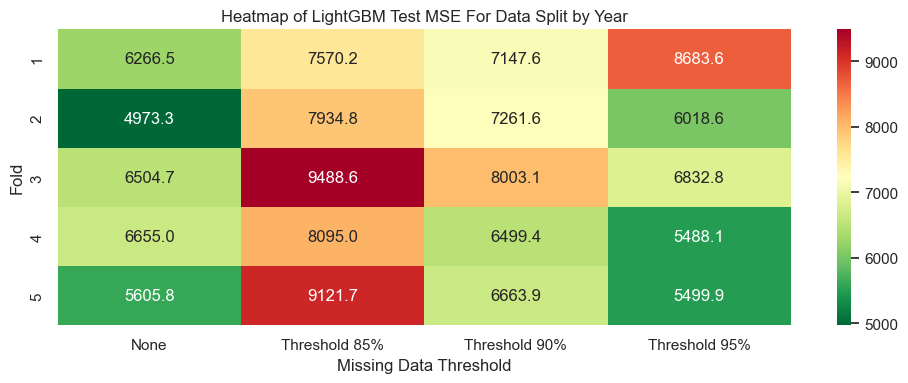

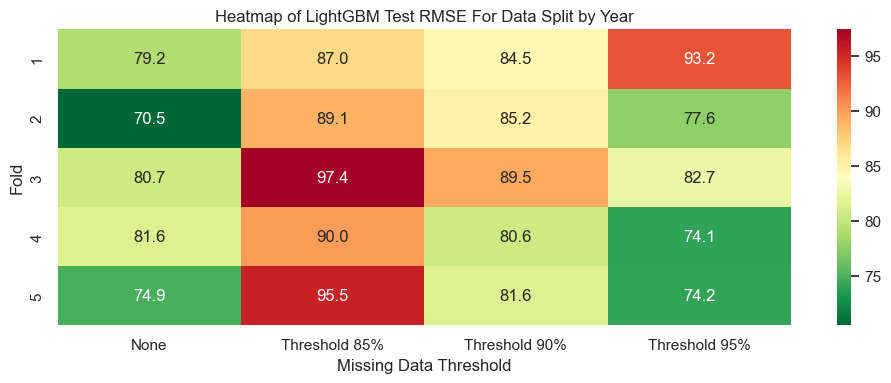

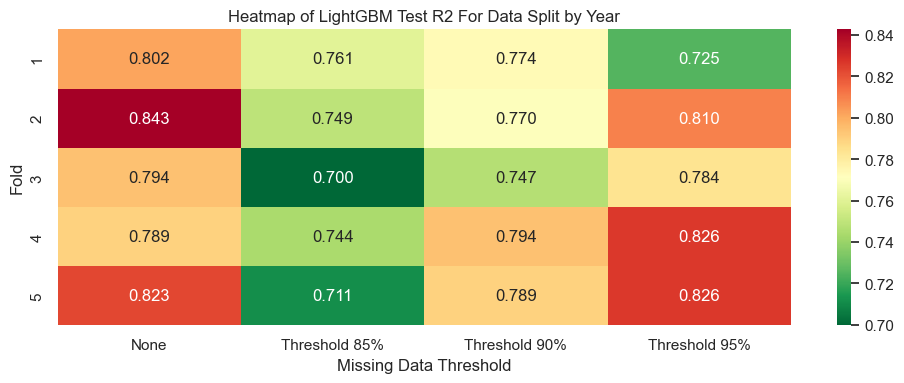

In [30]:
import seaborn as sns

data_lgbm = test_stats['LightGBM'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'Relative Error' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of LightGBM Test " + metric + " For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [31]:
lgbm_data = test_stats['LightGBM'].astype(float)
mean_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').mean()
mean_summary_lgbm = mean_summary_lgbm.astype('float')
mean_summary_lgbm = mean_summary_lgbm.round(2)
std_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').std()
std_summary_lgbm = std_summary_lgbm.astype('float')
std_summary_lgbm = std_summary_lgbm.round(2)

In [32]:
mean_corr_lgbm = mean_summary_lgbm.corr()
mean_corr_lgbm

Evaluation Metric,Relative Error,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
Relative Error,1.000000,0.211834,0.783907,0.766437,-0.760695
MAE,0.211834,1.000000,0.767639,0.784805,-0.782735
MSE,0.783907,0.767639,1.000000,0.999617,-0.998345
RMSE,0.766437,0.784805,0.999617,1.000000,-0.998906
R2,-0.760695,-0.782735,-0.998345,-0.998906,1.000000


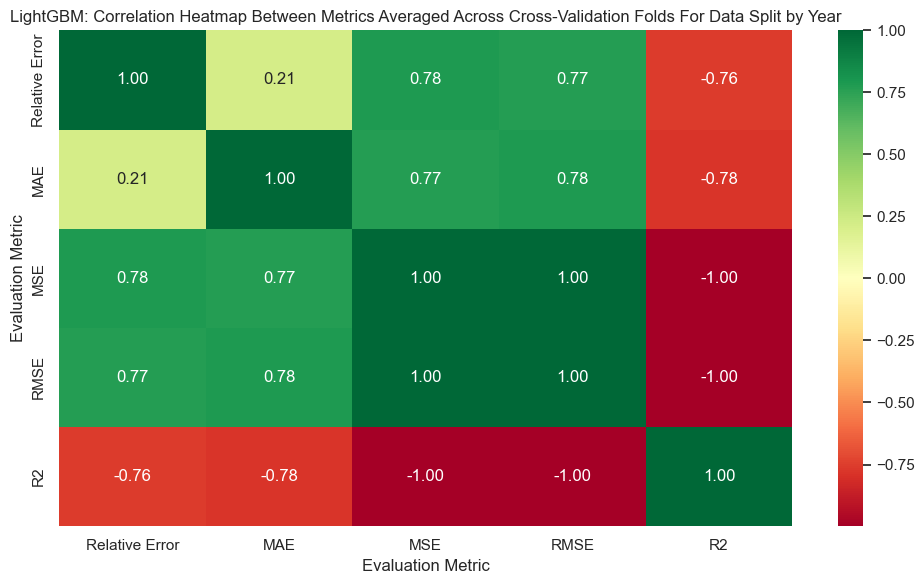

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_lgbm, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Year")
plt.tight_layout()
plt.show()

### XGBoost

#### Data Collection

In [13]:
xgb_params = pd.DataFrame(index=index_rows, columns=['n_estimators', 'max_depth', 'booster', 
                                                     'subsample', 'learning_rate','reg_alpha', 'reg_lambda'])

In [14]:
testing_x = test_data_x.copy()

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        xgb_params.loc[(thresh_name, fold_num)] = param_list

        train_input_data = train[fold][thresh * 2].copy()
        train_label = train[fold][thresh * 2 + 1].copy()

        to_test = testing_x[train_input_data.columns].copy()

        loaded_model = xgb.XGBRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate re
        num_predictions = len(prediction)
        re = 0
        for p in range(0, num_predictions):
            re += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        re = re/num_predictions
        #re = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'Relative Error')] = re[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/915716556.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/915716556.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/915716556.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

#### Visualisations

In [36]:
xgb_params

n_estimators max_depth booster subsample  \
Missing Data Threshold Fold                                            
Threshold 85%          1             NaN       NaN     NaN       NaN   
                       2             NaN       NaN     NaN       NaN   
                       3             NaN       NaN     NaN       NaN   
                       4             NaN       NaN     NaN       NaN   
                       5             NaN       NaN     NaN       NaN   
Threshold 90%          1             NaN       NaN     NaN       NaN   
                       2             NaN       NaN     NaN       NaN   
                       3             NaN       NaN     NaN       NaN   
                       4             NaN       NaN     NaN       NaN   
                       5             NaN       NaN     NaN       NaN   
Threshold 95%          1             NaN       NaN     NaN       NaN   
                       2             NaN       NaN     NaN       NaN   
                       3             NaN       NaN     NaN       NaN   
                       4             NaN       NaN     NaN       NaN   
                       5             NaN       NaN     NaN       NaN   
None                   1             NaN       NaN     NaN       NaN   
                       2             NaN       NaN     NaN       NaN   
                       3             NaN       NaN     NaN       NaN   
                       4             NaN       NaN     NaN       NaN   
                       5             NaN       NaN     NaN       NaN   

                            learning_rate reg_alpha reg_lambda  
Missing Data Threshold Fold                                     
Threshold 85%          1              NaN       NaN        NaN  
                       2              NaN       NaN        NaN  
                       3              NaN       NaN        NaN  
                       4              NaN       NaN        NaN  
                       5              NaN       NaN        NaN  
Threshold 90%          1              NaN       NaN        NaN  
                       2              NaN       NaN        NaN  
                       3              NaN       NaN        NaN  
                       4              NaN       NaN        NaN  
                       5              NaN       NaN        NaN  
Threshold 95%          1              NaN       NaN        NaN  
                       2              NaN       NaN        NaN  
                       3              NaN       NaN        NaN  
                       4              NaN       NaN        NaN  
                       5              NaN       NaN        NaN  
None                   1              NaN       NaN        NaN  
                       2              NaN       NaN        NaN  
                       3              NaN       NaN        NaN  
                       4              NaN       NaN        NaN  
                       5              NaN       NaN        NaN

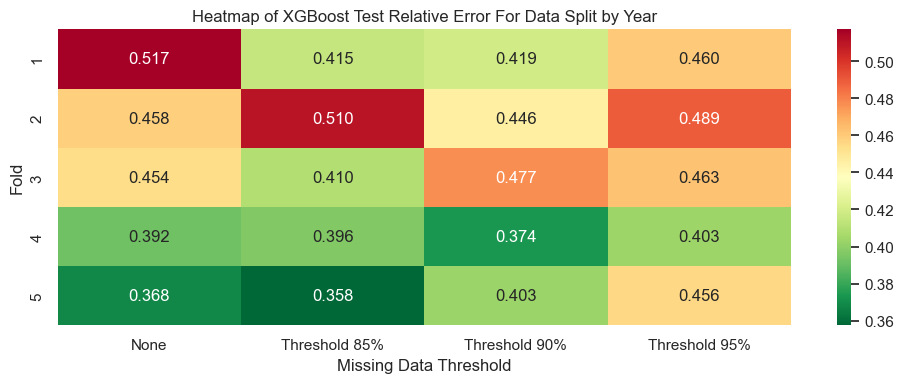

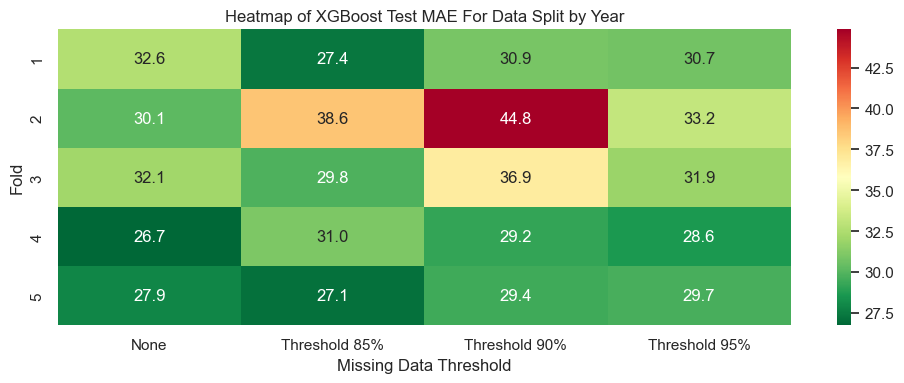

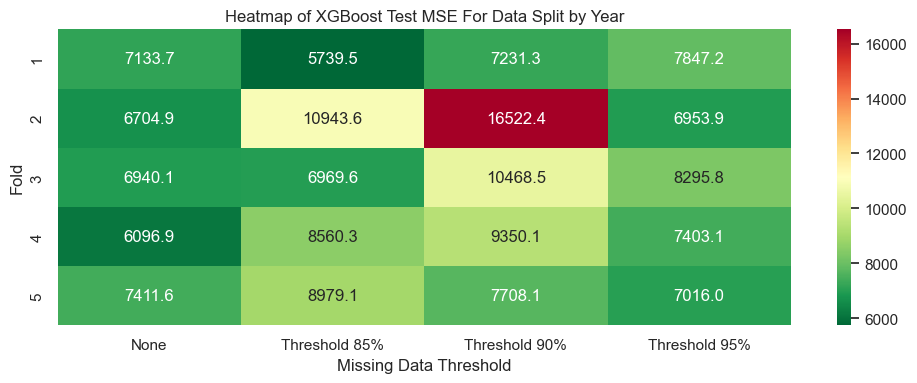

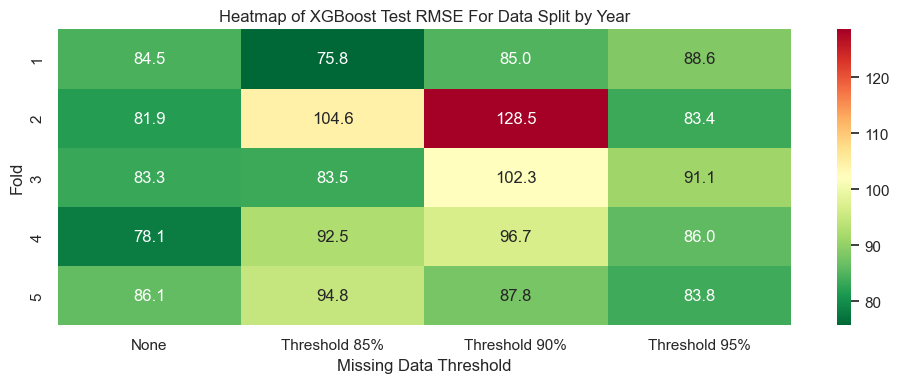

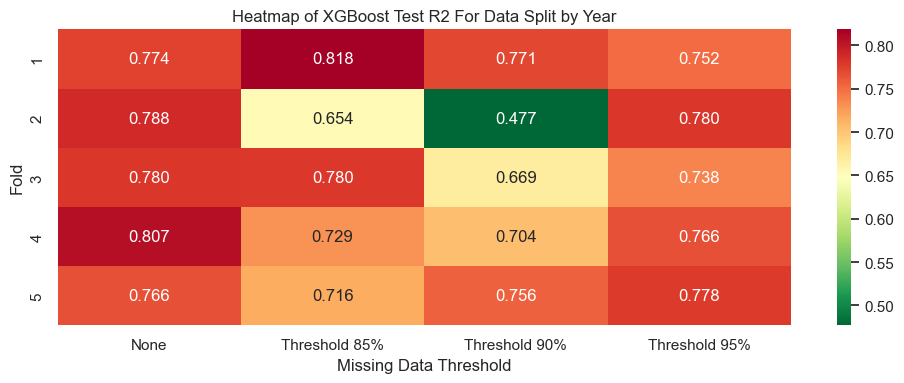

In [37]:
import seaborn as sns

data_lgbm = test_stats['XGBoost'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'Relative Error' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of XGBoost Test " + metric + " For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [38]:
xgb_data = test_stats['XGBoost'].astype(float)
mean_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').mean()
mean_summary_xgb = mean_summary_xgb.astype('float')
mean_summary_xgb = mean_summary_xgb.round(2)
std_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').std()
std_summary_xgb = std_summary_xgb.astype('float')
std_summary_xgb = std_summary_xgb.round(2)

In [39]:
mean_corr_xgb = mean_summary_xgb.corr()
mean_corr_xgb

Evaluation Metric,Relative Error,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
Relative Error,1.000000,-0.566011,-0.730461,-0.727044,0.720082
MAE,-0.566011,1.000000,0.969598,0.965431,-0.972425
MSE,-0.730461,0.969598,1.000000,0.999384,-0.999885
RMSE,-0.727044,0.965431,0.999384,1.000000,-0.999389
R2,0.720082,-0.972425,-0.999885,-0.999389,1.000000


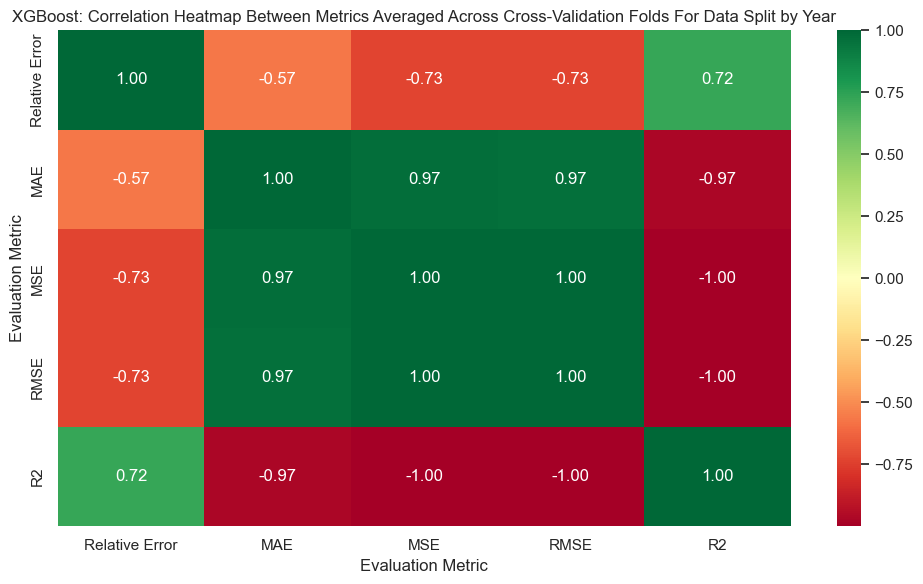

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_xgb, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("XGBoost: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Year")
plt.tight_layout()
plt.show()

### Random Forest

#### Data Collection

In [15]:
rf_params = pd.DataFrame(index=index_rows, columns=['n_estimators', 'max_depth', 'min_samples_split', 
                                                     'bootstrapping', 'max_samples'])

In [16]:
testing_x_rf = testing_x.copy()

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/rf/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        rf_params.loc[(thresh_name, fold_num)] = param_list
        train_input_data = train[fold][thresh * 2].copy()

        test_relevant_input = testing_x_rf[train_input_data.columns]

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        prediction = train_load.predict(test_relevant_input)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate re
        num_predictions = len(prediction)
        re = 0
        for p in range(0, num_predictions):
            re += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        
        re = re/num_predictions

        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'Relative Error')] = re[0]
        

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_7688/3161195273.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'Relative Error')] = re[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_76

#### Visualisations

In [43]:
rf_params

n_estimators max_depth min_samples_split  \
Missing Data Threshold Fold                                            
Threshold 85%          1             NaN       NaN               NaN   
                       2             NaN       NaN               NaN   
                       3             NaN       NaN               NaN   
                       4             NaN       NaN               NaN   
                       5             NaN       NaN               NaN   
Threshold 90%          1             NaN       NaN               NaN   
                       2             NaN       NaN               NaN   
                       3             NaN       NaN               NaN   
                       4             NaN       NaN               NaN   
                       5             NaN       NaN               NaN   
Threshold 95%          1             NaN       NaN               NaN   
                       2             NaN       NaN               NaN   
                       3             NaN       NaN               NaN   
                       4             NaN       NaN               NaN   
                       5             NaN       NaN               NaN   
None                   1             NaN       NaN               NaN   
                       2             NaN       NaN               NaN   
                       3             NaN       NaN               NaN   
                       4             NaN       NaN               NaN   
                       5             NaN       NaN               NaN   

                            bootstrapping max_samples  
Missing Data Threshold Fold                            
Threshold 85%          1              NaN         NaN  
                       2              NaN         NaN  
                       3              NaN         NaN  
                       4              NaN         NaN  
                       5              NaN         NaN  
Threshold 90%          1              NaN         NaN  
                       2              NaN         NaN  
                       3              NaN         NaN  
                       4              NaN         NaN  
                       5              NaN         NaN  
Threshold 95%          1              NaN         NaN  
                       2              NaN         NaN  
                       3              NaN         NaN  
                       4              NaN         NaN  
                       5              NaN         NaN  
None                   1              NaN         NaN  
                       2              NaN         NaN  
                       3              NaN         NaN  
                       4              NaN         NaN  
                       5              NaN         NaN

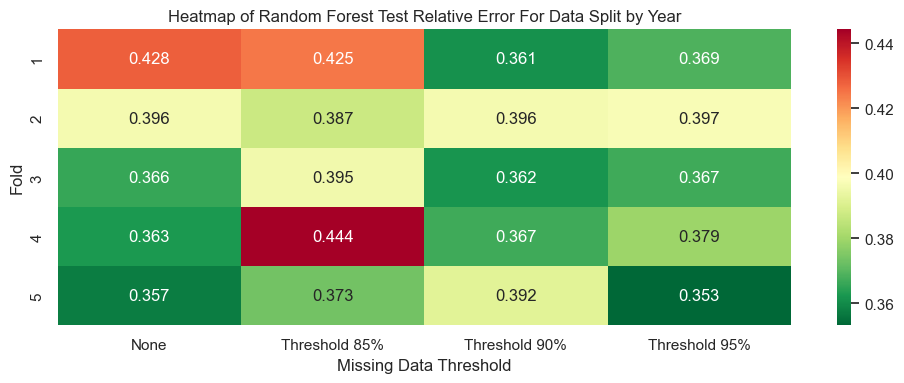

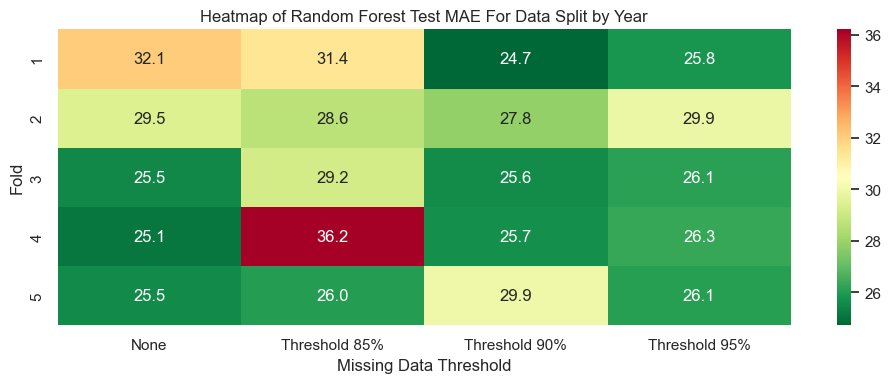

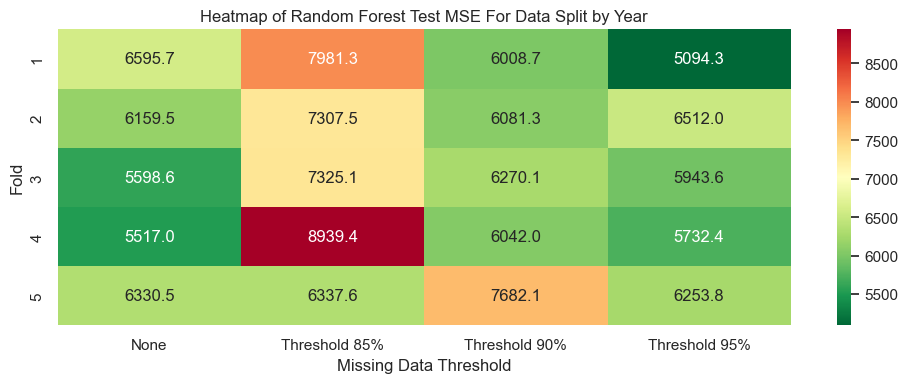

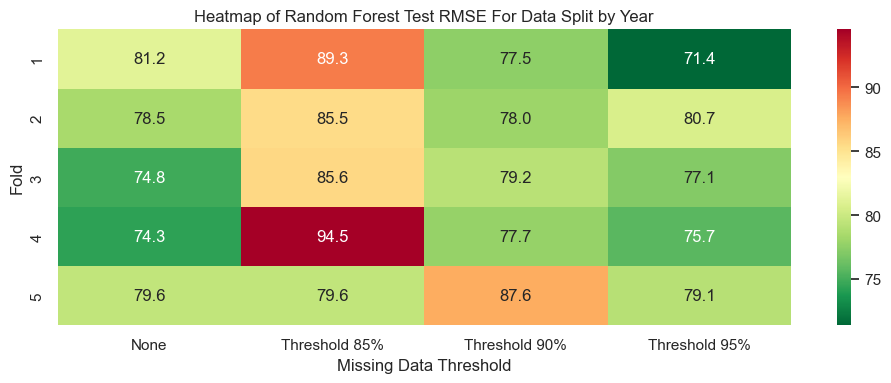

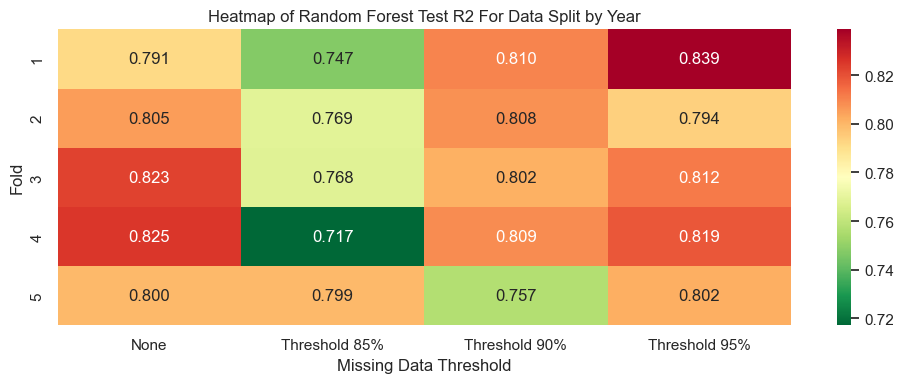

In [44]:
import seaborn as sns

data_rf = test_stats['Random Forest'].astype(float)

for metric in data_rf.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_rf[metric].unstack(level='Missing Data Threshold'))
    if metric == 'Relative Error' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric + " For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [45]:
rf_data = test_stats['Random Forest'].astype(float)
mean_summary_rf = rf_data.groupby(level='Missing Data Threshold').mean()
mean_summary_rf = mean_summary_rf.astype('float')
mean_summary_rf = mean_summary_rf.round(2)
std_summary_rf = rf_data.groupby(level='Missing Data Threshold').std()
std_summary_rf = std_summary_rf.astype('float')
std_summary_rf = std_summary_rf.round(2)

In [46]:
mean_corr_rf = mean_summary_rf.corr()
mean_corr_rf

Evaluation Metric,Relative Error,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
Relative Error,1.000000,0.937597,0.963666,0.964476,-0.945905
MAE,0.937597,1.000000,0.915262,0.911362,-0.933852
MSE,0.963666,0.915262,1.000000,0.999909,-0.994256
RMSE,0.964476,0.911362,0.999909,1.000000,-0.992744
R2,-0.945905,-0.933852,-0.994256,-0.992744,1.000000


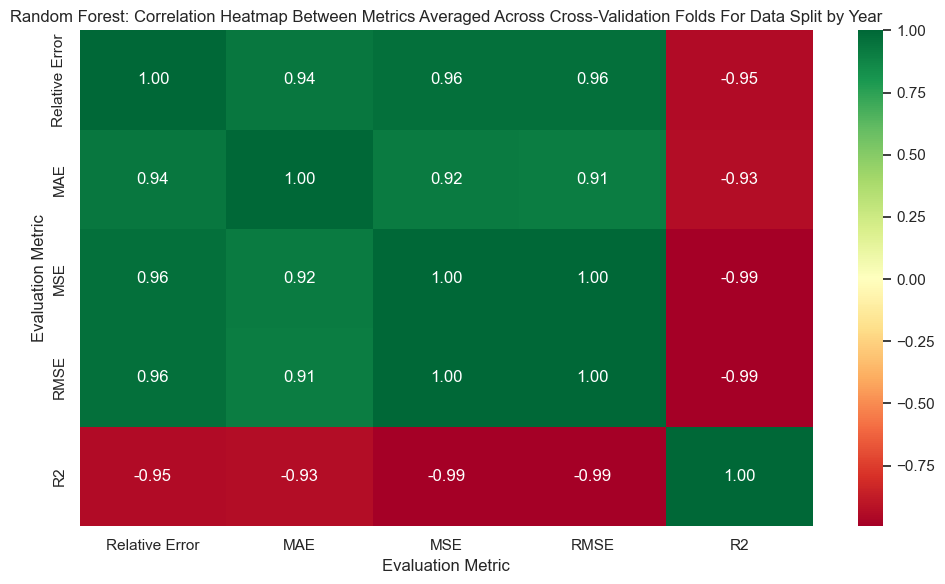

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_rf, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("Random Forest: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Year")
plt.tight_layout()
plt.show()

### Comparison Visualisations

In [90]:
mean_concat = pd.concat([mean_summary_lgbm, mean_summary_xgb, mean_summary_rf], axis=1)
mean_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'Relative Error'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'Relative Error'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'Relative Error'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
mean_concat = mean_concat.loc[['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']]

In [91]:
std_concat = pd.concat([std_summary_lgbm, std_summary_xgb, std_summary_rf], axis=1)
std_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'Relative Error'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'Relative Error'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'Relative Error'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
std_concat = std_concat.loc[['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']]

In [92]:
joblib.dump(mean_concat, f"../../split_year_models/base_mean_metrics.pkl")
joblib.dump(std_concat, f"../../split_year_models/base_std_metrics.pkl")

['../../split_year_models/base_std_metrics.pkl']

In [17]:
test_stats

Model                             LightGBM                                     \
Evaluation Metric           Relative Error        MAE          MSE       RMSE   
Missing Data Threshold Fold                                                     
Threshold 85%          1          0.410349  27.658347  7570.171851  87.006735   
                       2          0.435429  30.597563   7934.78238  89.077395   
                       3          0.641285  37.516279  9488.560785  97.409244   
                       4          0.515841  31.404015  8094.971174  89.972058   
                       5          0.697024   38.63424  9121.719752  95.507695   
Threshold 90%          1          0.434795  31.264448  7147.596426  84.543459   
                       2          0.437915  33.754223   7261.64581  85.215291   
                       3          0.612396  41.277823  8003.110426  89.460105   
                       4          0.445683  30.900625  6499.447026  80.619148   
                       5          0.466417  31.207259  6663.871292  81.632538   
Threshold 95%          1          0.579915  36.767469  8683.582532  93.185742   
                       2          0.391637  26.538653  6018.628628  77.579821   
                       3          0.638054  33.398192   6832.82467  82.660902   
                       4          0.437428  29.689441  5488.139389  74.081977   
                       5          0.431286  26.546511  5499.912664  74.161396   
None                   1          0.434615    28.3723  6266.491686  79.161175   
                       2          0.400621  26.964296  4973.297963  70.521613   
                       3          0.682517  38.178292    6504.6831  80.651616   
                       4          0.432688  29.250375  6655.029659  81.578365   
                       5           0.50293  29.716989  5605.849556  74.872222   

Model                                        XGBoost                           \
Evaluation Metric                  R2 Relative Error        MAE           MSE   
Missing Data Threshold Fold                                                     
Threshold 85%          1     0.760504       0.415457  27.357309   5739.473145   
                       2     0.748968       0.510342  38.555756  10943.635742   
                       3     0.699812       0.409877  29.800798   6969.643066   
                       4     0.743901       0.396435  30.997297     8560.3125   
                       5     0.711417       0.357605   27.09565    8979.12207   
Threshold 90%          1     0.773873       0.419165  30.863998   7231.297363   
                       2     0.770264       0.445658  44.839832  16522.351562   
                       3     0.746807       0.476978  36.915771  10468.472656   
                       4     0.794378        0.37356  29.179476   9350.139648   
                       5     0.789176       0.403064  29.432993   7708.077637   
Threshold 95%          1     0.725279       0.460087  30.742626   7847.205566   
                       2      0.80959       0.489224  33.225014   6953.903809   
                       3     0.783831       0.462801   31.87689   8295.834961   
                       4     0.826373       0.403185  28.592682   7403.133789   
                       5        0.826       0.455835  29.675377   7015.978516   
None                   1     0.801748       0.517089  32.640415   7133.651367   
                       2      0.84266       0.458133  30.133202   6704.945312   
                       3     0.794212       0.453984  32.099007   6940.136719   
                       4     0.789456        0.39212  26.739344   6096.924805   
                       5     0.822649       0.368432  27.877766   7411.565918   

Model                                              Random Forest             \
Evaluation Metric                  RMSE        R2 Relative Error        MAE   
Missing Data Threshold Fold                                                   
Threshold 85%          1      75.75

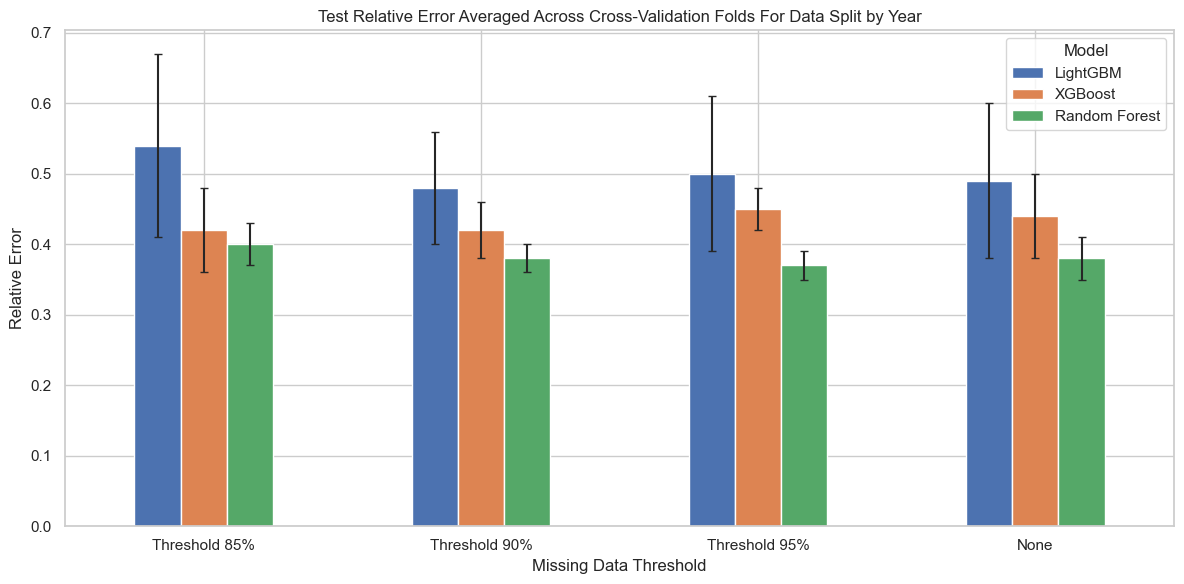

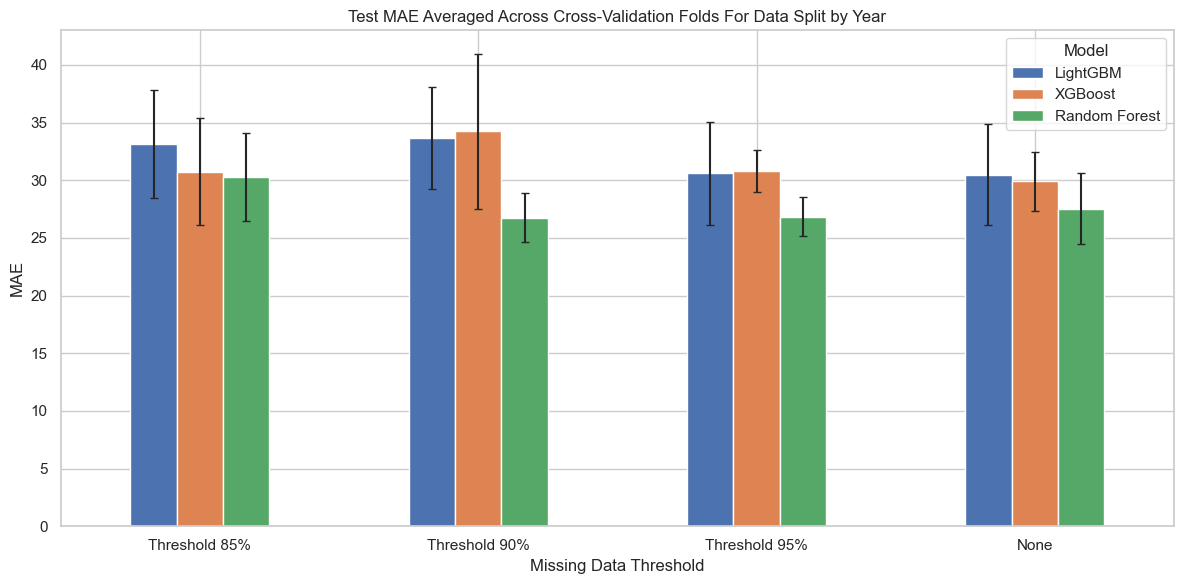

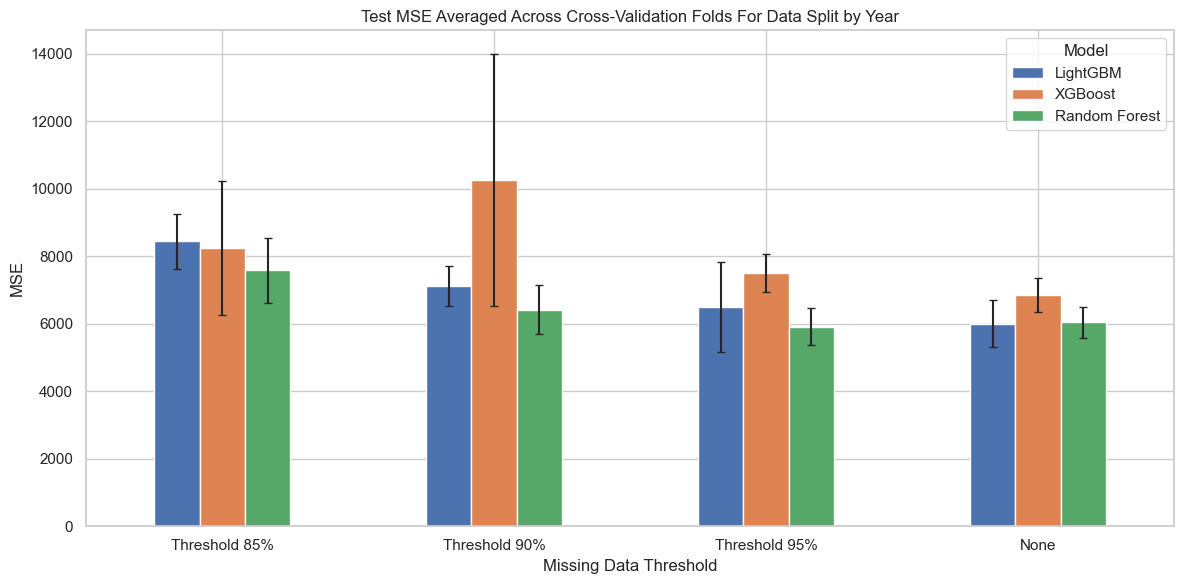

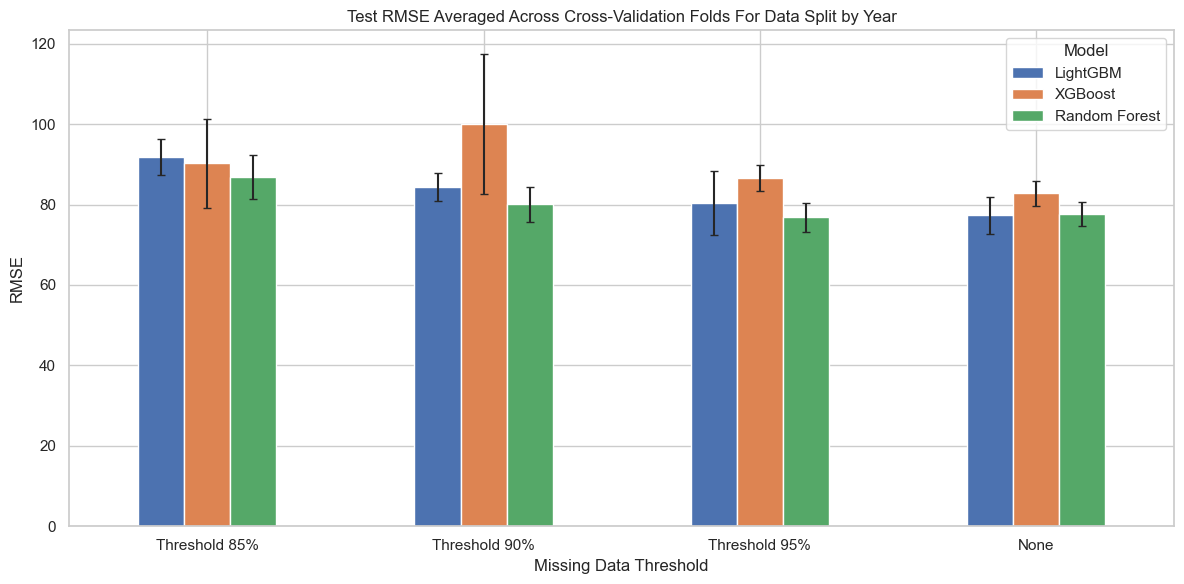

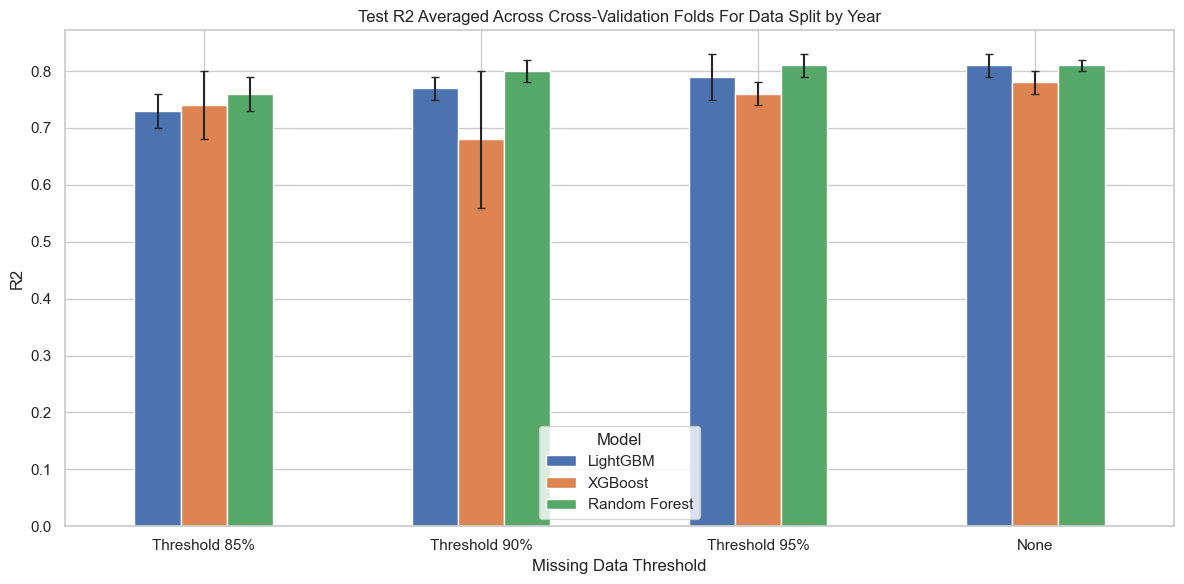

In [93]:
mean_concat = mean_concat.astype(float)
std_concat = std_concat.astype(float)

metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = mean_concat.index

for metric in metrics:
    data_metric = mean_concat.xs(metric, axis=1, level='Metric')
    error = std_concat.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6), capsize=3)     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Without XGB

In [73]:
without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_78239/2683943296.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_78239/2683943296.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)


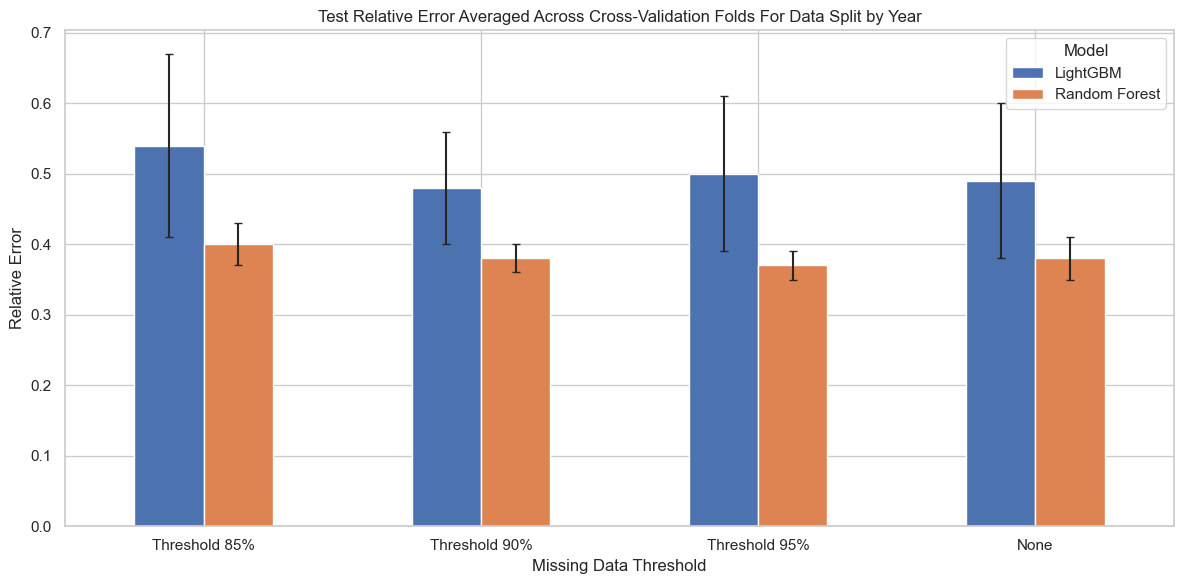

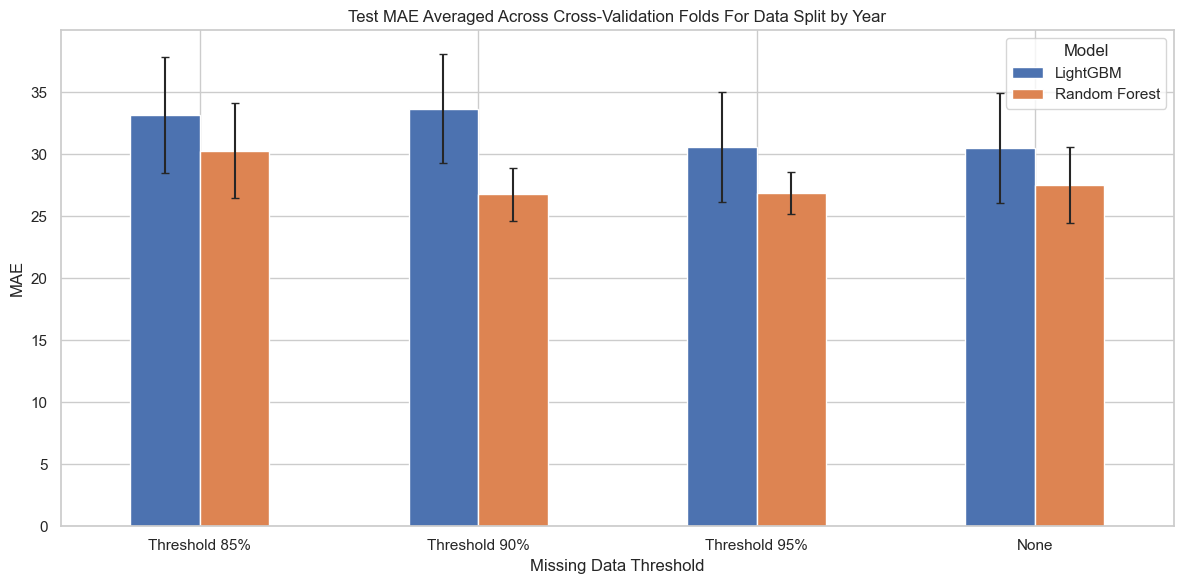

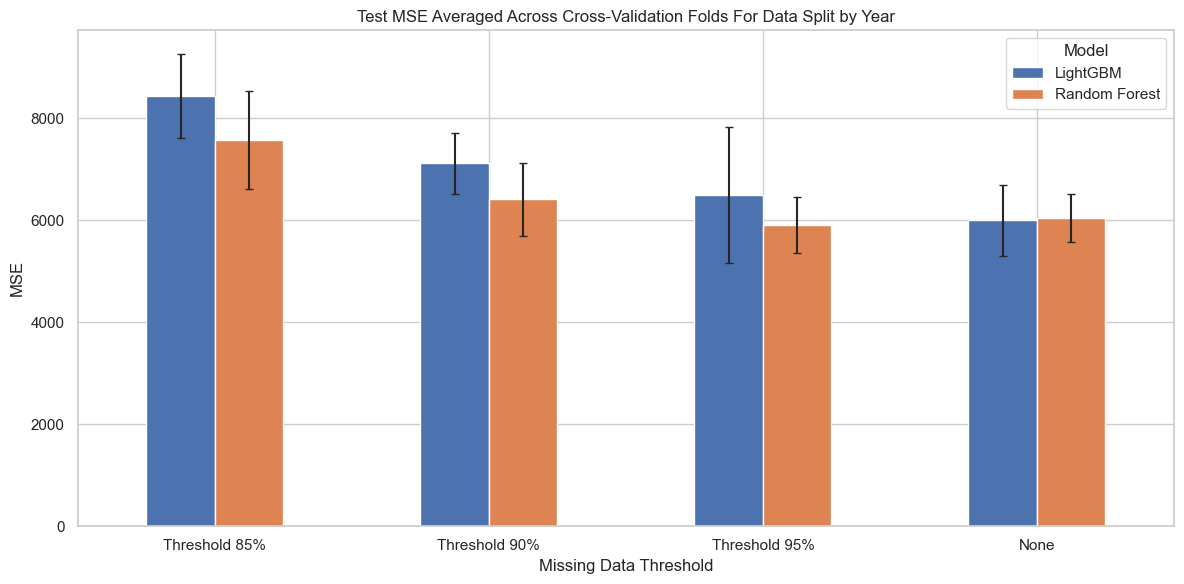

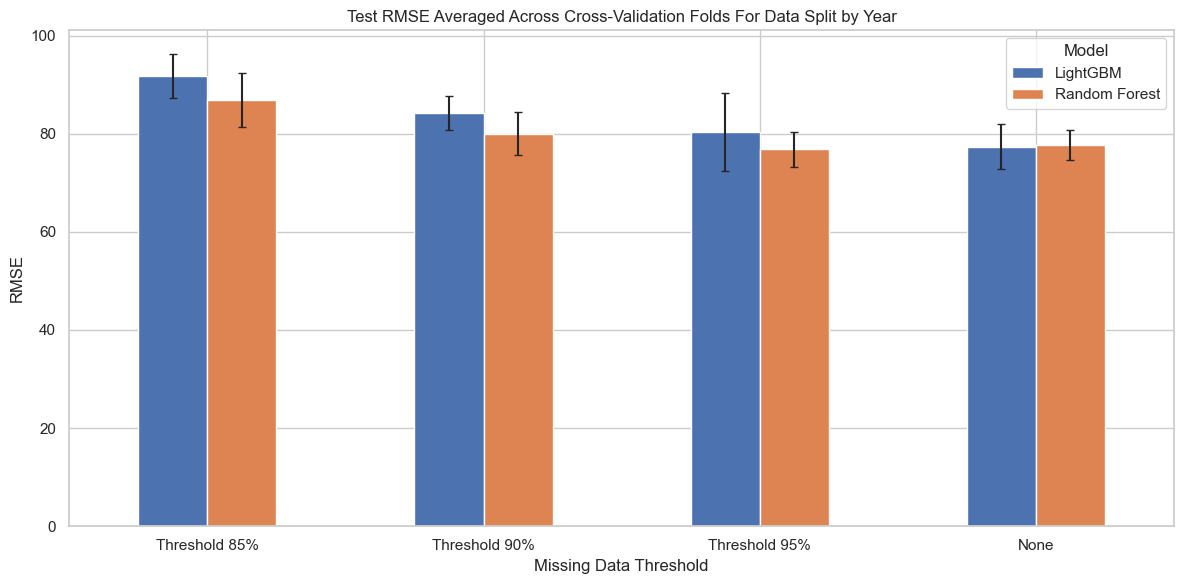

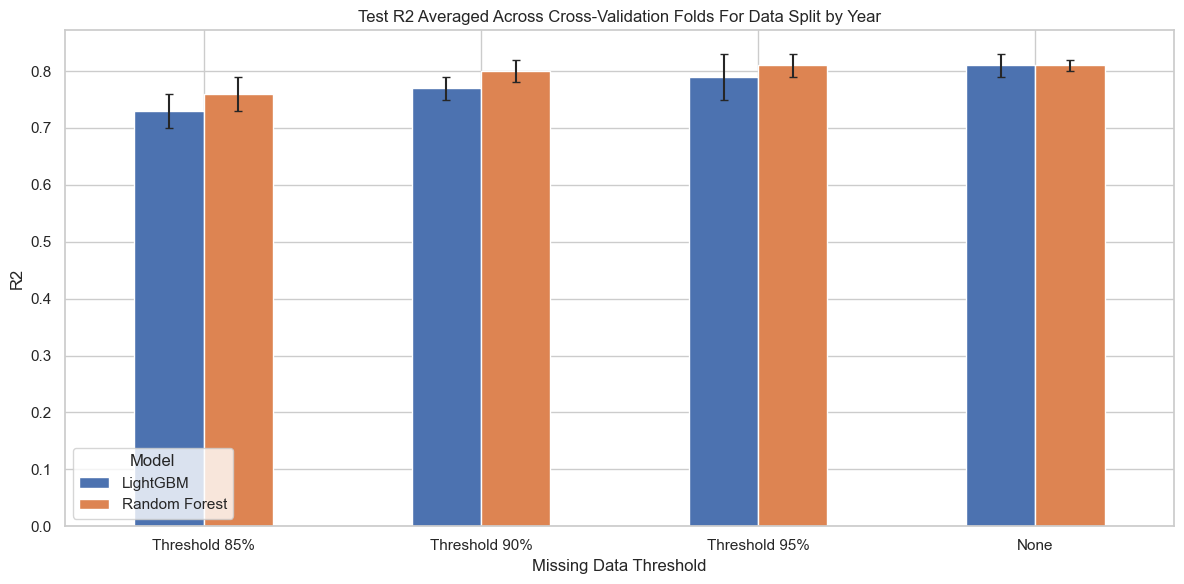

In [95]:
without_xgb = without_xgb.astype(float)
without_xgb_std = without_xgb_std.astype(float)

metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = without_xgb.index

for metric in metrics:
    data_metric = without_xgb.xs(metric, axis=1, level='Metric')
    error = without_xgb_std.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6), capsize=3)     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds For Data Split by Year")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Test vs Validation

#### Data Gathering

In [75]:
validation_mse_stats = pd.DataFrame(index=index_rows, columns=['xgboost', 'lightgbm', 'random_forest'])

In [76]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        for model in ['xgboost', 'lightgbm', 'rf']:
        
            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if model == 'rf':
                model_name = 'random_forest'
            else:
                model_name = model

            with open(f"{output_dir}/{model}/results_{fold}_{name}.json", 'r') as f:
                optuna_study = json.load(f)

            best_value = optuna_study["best_optuna_loss"]

            validation_mse_stats.loc[(thresh_name, fold_num), model_name] = best_value

In [77]:
mean_validation_mse = validation_mse_stats.groupby(level='Missing Data Threshold').mean()
mean_validation_mse = mean_validation_mse.astype('float')
std_validation_mse = validation_mse_stats.groupby(level='Missing Data Threshold').std()
std_validation_mse = std_validation_mse.astype('float')
mean_validation_mse.columns = ['XGBoost', 'LightGBM', 'Random Forest']
std_validation_mse.columns = ['XGBoost', 'LightGBM', 'Random Forest']

mean_concat_mse = mean_concat.xs('MSE', axis=1, level='Metric')
std_concat_mse = std_concat.xs('MSE', axis=1, level='Metric')

In [78]:
mean_none = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_none.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['None', 'XGBoost']
mean_none.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['None', 'LightGBM']
mean_none.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['None', 'Random Forest']
mean_none.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['None', 'XGBoost']
mean_none.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['None', 'LightGBM']
mean_none.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['None', 'Random Forest']

In [79]:
std_none = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_none.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['None', 'XGBoost']
std_none.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['None', 'LightGBM']
std_none.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['None', 'Random Forest']
std_none.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['None', 'XGBoost']
std_none.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['None', 'LightGBM']
std_none.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['None', 'Random Forest']

In [80]:
mean_95 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_95.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'XGBoost']
mean_95.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'LightGBM']
mean_95.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'Random Forest']
mean_95.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'XGBoost']
mean_95.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'LightGBM']
mean_95.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'Random Forest']

In [81]:
std_95 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_95.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'XGBoost']
std_95.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'LightGBM']
std_95.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'Random Forest']
std_95.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'XGBoost']
std_95.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'LightGBM']
std_95.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'Random Forest']

In [82]:
mean_85 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_85.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'XGBoost']
mean_85.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'LightGBM']
mean_85.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'Random Forest']
mean_85.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'XGBoost']
mean_85.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'LightGBM']
mean_85.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'Random Forest']

In [83]:
std_85 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_85.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'XGBoost']
std_85.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'LightGBM']
std_85.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'Random Forest']
std_85.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'XGBoost']
std_85.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'LightGBM']
std_85.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'Random Forest']

In [84]:
mean_90 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_90.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 90%', 'XGBoost']
mean_90.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 90%', 'LightGBM']
mean_90.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 90%', 'Random Forest']
mean_90.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 90%', 'XGBoost']
mean_90.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 90%', 'LightGBM']
mean_90.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 90%', 'Random Forest']

In [85]:
std_90 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_90.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 90%', 'XGBoost']
std_90.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 90%', 'LightGBM']
std_90.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 90%', 'Random Forest']
std_90.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 90%', 'XGBoost']
std_90.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 90%', 'LightGBM']
std_90.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 90%', 'Random Forest']

#### Visualisation

In [87]:
mean_validation_scores = [mean_85, mean_90, mean_95, mean_none]
std_validation_scores = [std_85, std_90, std_95, std_none]

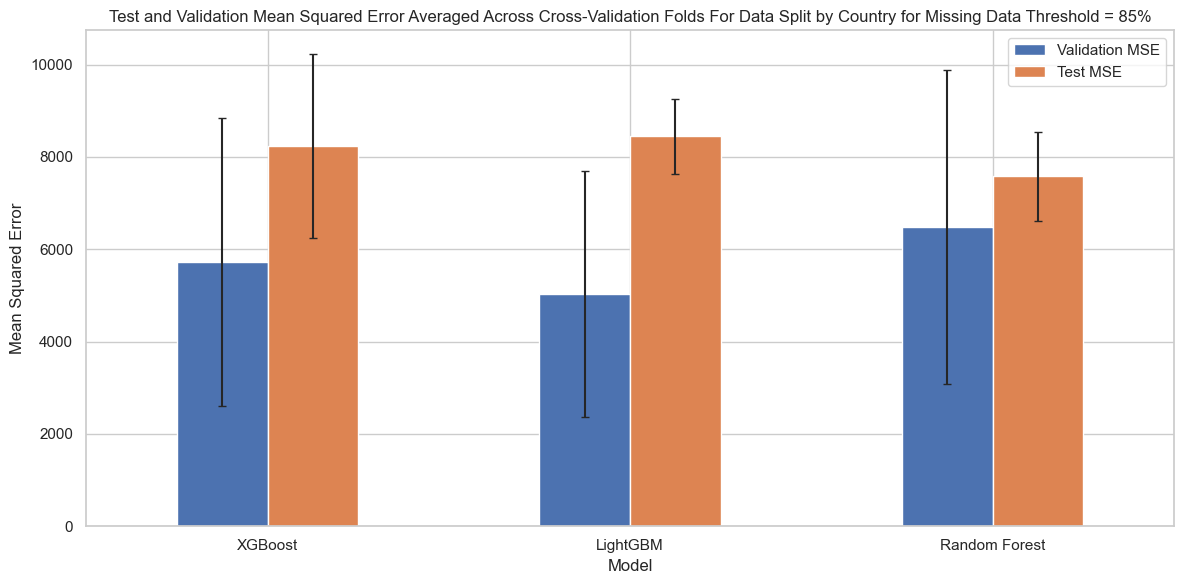

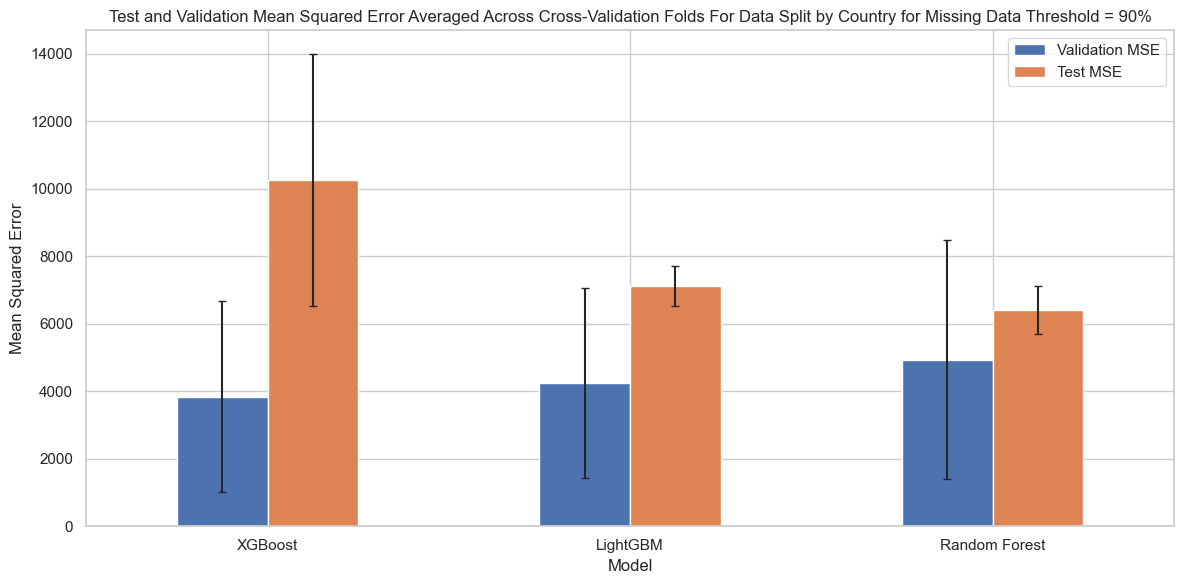

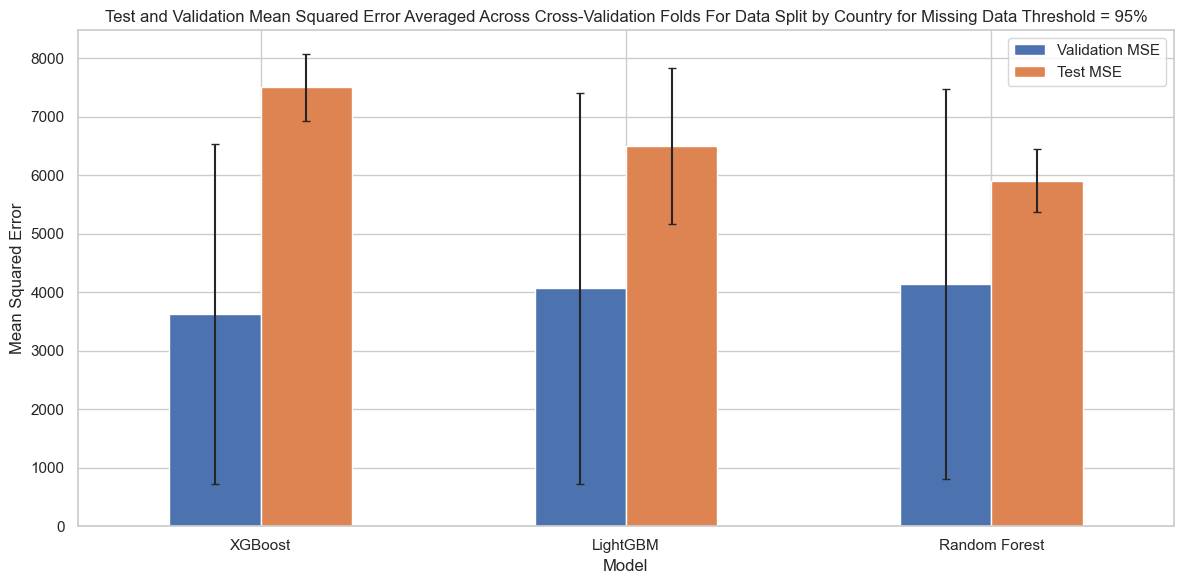

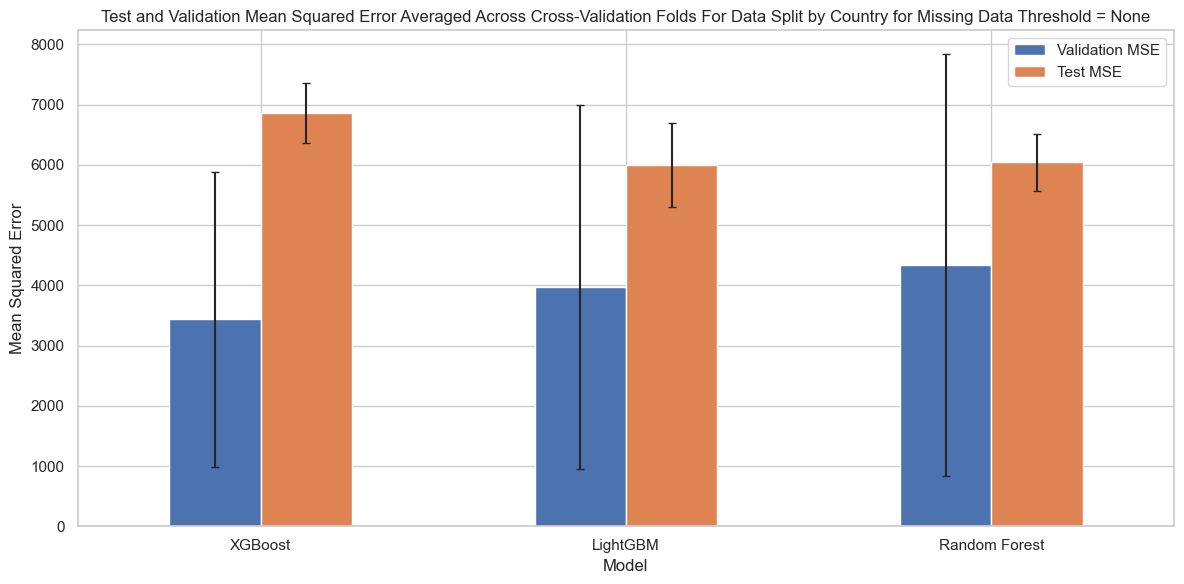

In [94]:
bar_index = ['XGBoost', 'LightGBM', 'Random Forest']

for i in range(4):

    if i == 0:
        threshold = '85%'
    elif i == 1:
        threshold = '90%'
    elif i == 2:
        threshold = '95%'
    else: threshold = 'None'

    ax = mean_validation_scores[i].plot.bar(rot=0, yerr=std_validation_scores[i], figsize=(12, 6), capsize=3)     
    plt.title("Test and Validation Mean Squared Error Averaged Across Cross-Validation Folds For Data Split by Country for Missing Data Threshold = " + threshold)
    plt.xlabel("Model")
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()